# Semantic Segmentation of aerial images with Fully Convolutional Network


This notebook presents a straightforward PyTorch implementation of a *Fully Convolutional Network* for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes. Here, we adapt the baseline implementation of the SegNet model presented in "[Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks](https://hal.archives-ouvertes.fr/hal-01636145) ", Nicolas Audebert, Bertrand Le Saux and Sébastien Lefèvre, ISPRS Journal, 2018.


## Workspace utilities


In [1]:
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn

# PyTorch related Libraries
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.io import read_image
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning import LightningDataModule


from PIL import Image
import torchgeo


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torchgeo.datasets import LandCoverAI
from torchgeo.datamodules import LandCoverAIDataModule
from torchgeo.datasets.landcoverai import LandCoverAI
from torchvision.transforms import ToTensor


import os
import cv2

## Datasets

The LandCover.ai dataset is a semantic segmentation dataset [5] that consists of
high-resolution (0.5 m/px and 0.25 m/px) RGB aerial imagery from 41 tiles over Poland where
each pixel has been classified as one of five classes (four land cover classes and a “background”
class). The scenes are divided into 10,674 512 × 512 pixel patches and partitioned into
pre-defined training, validation, and test splits according to the script on the dataset webpage2.

The LandCover.ai (Land Cover from Aerial Imagery) dataset is a dataset for automatic mapping of buildings, woodlands, water and roads from aerial images. 

Dataset features:
- land cover from Poland, Central Europe
- three spectral bands - RGB
- 33 orthophotos with 25 cm per pixel resolution (~9000x9500 px)
- 8 orthophotos with 50 cm per pixel resolution (~4200x4700 px)
- total area of 216.27 km2

Dataset format:
- rasters are three-channel GeoTiffs with EPSG:2180 spatial reference system
- masks are single-channel GeoTiffs with EPSG:2180 spatial reference system

Dataset classes:
- building (1.85 km2)
- woodland (72.02 km2)
- water (13.15 km2)
- road (3.5 km2)

Reference:
- https://openreview.net/pdf?id=ZgV2C9NKk6Q
- https://torchgeo.readthedocs.io/en/stable/api/datasets.html




In [2]:
train_data = LandCoverAI("./data", split="train", transforms=ToTensor())
test_data = LandCoverAI("./data", split="test", transforms=ToTensor())
val_data = LandCoverAI("./data", split="val", transforms= ToTensor())

In [22]:
# labels_map = {
#     0: "Unclassified",
#     1: "Building",
#     2: "Woodland",
#     3: "Water",
#     4: "Road"
# }
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_data), size=(1,)).item()
#     img, label = train_data[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [3]:
land = LandCoverAIDataModule("./data", batch_size=16, num_workers=4)
land.setup()
train = land.train_dataloader()

In [6]:
for idx, batch in enumerate(train):
    #print(len(batch["image"][0]))
    print(batch["image"].shape)
    break

torch.Size([16, 3, 512, 512])


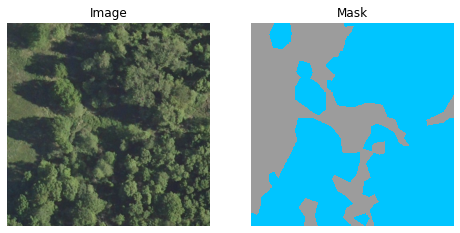

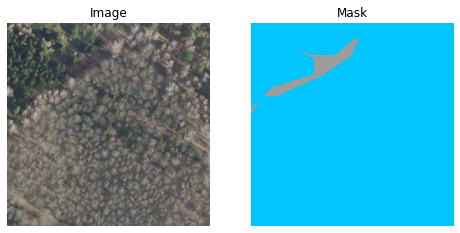

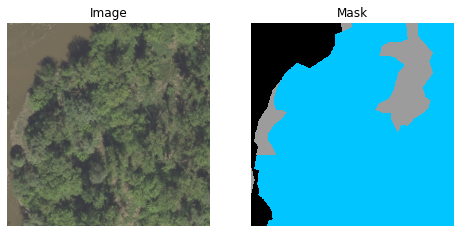

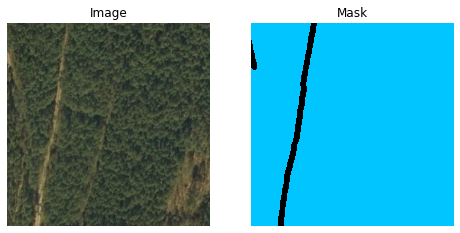

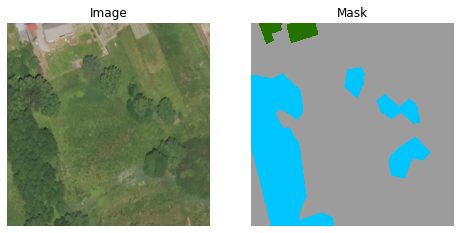

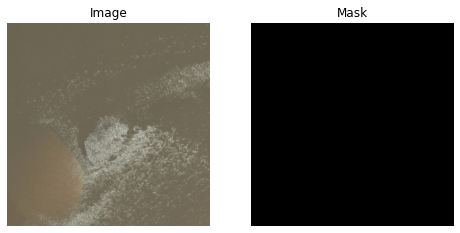

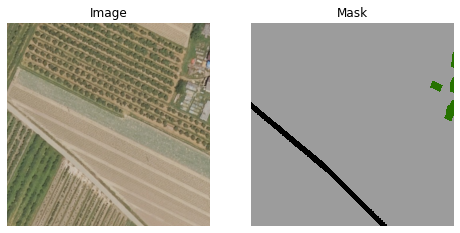

In [8]:
# SHOW Sample image
for idx, batch in enumerate(train):
    #print(len(batch["image"][0]))
    land.plot(sample =dict(image = batch["image"][0], mask = batch["mask"][0]) )
    #batch = land.on_after_batch_transfer(batch, idx)
    #land.plot(sample =dict(image = batch["image"][0], mask = batch["mask"][0]) )
    if idx > 5:
        break

DATA LOADER

In [9]:
# DATA LOADER
class LandData(LightningDataModule):
    def __init__(self, DATA_DIR, BATCH_SIZE, num_workers = int(os.cpu_count()/2)):
        """
        Lightning Data Module to load in the train, validation, and test data loader 
        from the Landcover.ai data repository to be passed 

        Args:
            DATA_DIR (str[Path]): Path to the image directory
            BATCHSIZE ([int]): number of samples to be passed to the network at each iteration
            num_workers ([int], optional): [the number of sub processes to use for data loading].
            Defaults to int(os.cpu_count()/2).
        """
        super().__init__()
        self.DATA_DIR = DATA_DIR
        self.batch_size = BATCH_SIZE

    def prepare_data(self):
        LandCoverAI(self.DATA_DIR, split="train", download=True)
        LandCoverAI(self.DATA_DIR, split="val", download=True)
        LandCoverAI(self.DATA_DIR, split="test", download=True)
    
    def setup(self, stage = None):
        train_size = 0.7
        if stage == "fit" or stage is None:
            self.LandCover_train = LandCoverAI(self.DATA_DIR, split="train", transforms= None)
            self.LandCover_val = LandCoverAI(self.DATA_DIR, split="val", transforms= None)

        if stage == "test" or stage is None:
            self.LandCover_test = LandCoverAI(self.DATA_DIR, split="test", transforms=None)

    def train_dataloader(self):
        return DataLoader(self.LandCover_train)

    def val_dataloader(self):
        return DataLoader(self.LandCover_val)

    def test_dataloader(self):
        return DataLoader(self.LandCover_test)        

In [10]:
land_data = LandData("./data", BATCH_SIZE=16)
land_data.prepare_data()
land_data.setup()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
print("The length of the training dataset is: ", len(land_data.train_dataloader() ) )
print("The length of the validation dataset is: ", len(land_data.val_dataloader() ) )
print("The length of the test dataset is: ", len(land_data.test_dataloader() ) )

The length of the training dataset is:  7470
The length of the validation dataset is:  1602
The length of the test dataset is:  1602


In [12]:
land_data.LandCover_train.classes

['Background', 'Building', 'Woodland', 'Water', 'Road']

In [ ]:
# DATA LOADER
class LandData(LightningDataModule):
    def __init__(self, DATA_DIR, BATCH_SIZE, num_workers = int(os.cpu_count()/2)):
        """
        Lightning Data Module to load in the train, validation, and test data loader 
        from the Landcover.ai data repository to be passed 

        Args:
            DATA_DIR (str[Path]): Path to the image directory
            BATCHSIZE ([int]): number of samples to be passed to the network at each iteration
            num_workers ([int], optional): [the number of sub processes to use for data loading].
            Defaults to int(os.cpu_count()/2).
        """
        super().__init__()
        self.DATA_DIR = DATA_DIR
        self.batch_size = BATCH_SIZE

    def prepare_data(self):
        LandCoverAI(self.DATA_DIR, split="train", download=True)
        LandCoverAI(self.DATA_DIR, split="val", download=True)
        LandCoverAI(self.DATA_DIR, split="test", download=True)
    
    def setup(self, stage = None):
        train_size = 0.7
        if stage == "fit" or stage is None:
            self.LandCover_train = LandCoverAI(self.DATA_DIR, split="train", transforms= None)
            self.LandCover_val = LandCoverAI(self.DATA_DIR, split="val", transforms= None)

        if stage == "test" or stage is None:
            self.LandCover_test = LandCoverAI(self.DATA_DIR, split="test", transforms=None)

    def train_dataloader(self):
        return DataLoader(self.LandCover_train)

    def val_dataloader(self):
        return DataLoader(self.LandCover_val)

    def test_dataloader(self):
        return DataLoader(self.LandCover_test)        

In [99]:
batch["image"].dim()

4

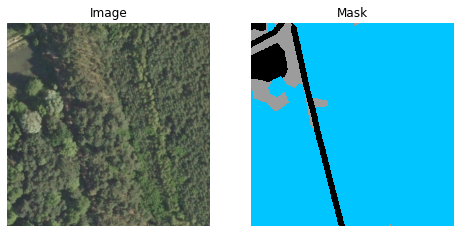

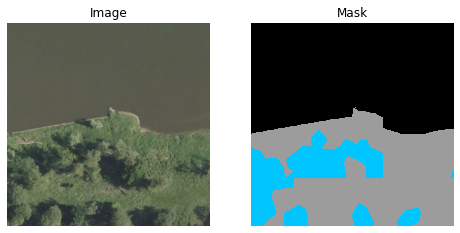

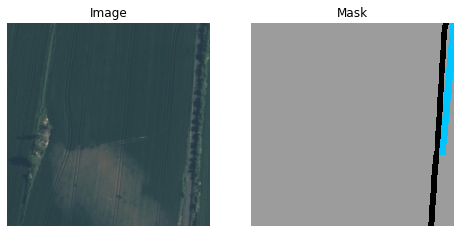

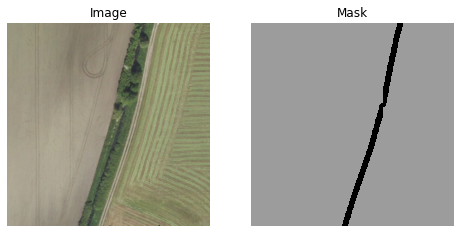

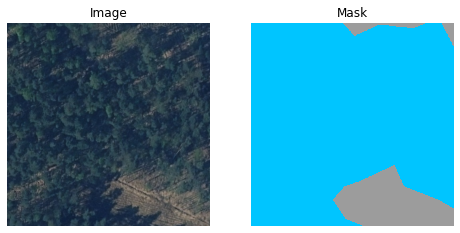

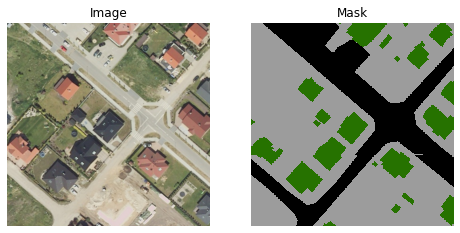

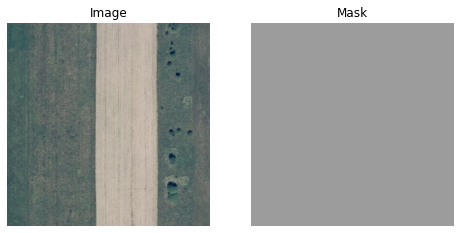

In [96]:
# SHOW Sample image
for idx, batch in enumerate(train):
    #print(len(batch["image"][0]))
    land.plot(sample =dict(image = batch["image"][0], mask = batch["mask"][0]) )
    batch = land.on_after_batch_transfer(batch, idx)
    #land.plot(sample =dict(image = batch["image"][0], mask = batch["mask"][0]) )
    if idx > 5:
        break

In [14]:
land_data.train_dataloader()

In [105]:
# dataset = next(iter(land_data.train_dataloader() ))
# image, labels = dataset[0], dataset[1]
# image.shape, labels.shape

In [37]:
# from torchvision.utils import make_grid
# dataset = land_data.train_dataloader()
# # display image patches in the train samples

# for batch in dataset:
#     dataiter = iter(batch)
#     visualize_land_data(sample = batch)

## SegNet Model
-
-
-


In [196]:
IN_CHANNELS = 3
N_CLASSES = 4
WINDOW_SIZE = (160, 160) # Patch size 160×160
STRIDE = 32 # Stride for testing

In [197]:
# DEFINE SegNet Model
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x

In [198]:
net = SegNet()

In [18]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [199]:
import segmentation_models_pytorch as smp
from pytorch_lightning import LightningModule
import torch

In [200]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

model = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes= 5
)

preprocess_input = get_preprocessing_fn('mobilenet_v2', pretrained='imagenet')

In [201]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

In [202]:
import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import WandbLogger
import torchmetrics

In [203]:
batch["mask"].dim()

3

In [204]:
import torch

class Criterion(torch.nn.Module):
    """Cross Entropy"""
            
    def __init__(self):
        super().__init__()

    def forward(logit, target, weight=None, size_average=True):
        """ 2D version of the cross entropy loss """
        dim = logit.dim()
        
        if dim == 2:
            return F.cross_entropy(logit, target, weight, size_average)
            ##return nn.CrossEntropyLoss(output, target,weight)
        elif dim == 4:
            output = logit.view(logit.size(0),input.size(1), -1)
            output = torch.transpose(output,1,2).contiguous()
            output = output.view(-1,output.size(2))
            target = target.view(-1)
            return F.cross_entropy(output, target,weight, size_average)
            ##return nn.CrossEntropyLoss(output, target,weight)
        else:
            raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

In [159]:
#%%file ./landsegnet.py
import segmentation_models_pytorch as smp
from pytorch_lightning import LightningModule
import torch
from torchvision.transforms import ToTensor
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class LandSegNet(LightningModule):
    """
    Lightning model for implementing the SegNet Model
    """

    def __init__(
        self,
        DATA_DIR,
        BATCH_SIZE,
        in_channels,
        out_channels,
        num_workers = int(os.cpu_count()/2),
        hparams: dict = {}
        ):

        super().__init__()
        # self.model = smp.create_model(
        #     arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_channels, **kwargs
        # )

        self.DATA_DIR = DATA_DIR
        self.batch_size = BATCH_SIZE
        self.num_workers = num_workers
        self.transform = transforms.Compose([transforms.ToTensor()])

        self.accuracy = torchmetrics.Accuracy()

        self.loss = Criterion()
        self.net = SegNet()

        self.gpu = self.hparams.get("gpu", False)

        ## LOAD VGG16 as the Weight of the Backbone
        vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
        mapped_weights = {}
        
        for k_vgg, k_segnet in zip(vgg16_weights.keys(), self.net.state_dict().keys()):
            if "features" in k_vgg:
                mapped_weights[k_segnet] = vgg16_weights[k_vgg]
                print("Mapping {} to {}".format(k_vgg, k_segnet))
        try:
            self.net.load_state_dict(mapped_weights)
            print("Loaded VGG-16 weights in SegNet !")
        except:
            # Ignore missing keys
            pass


    def prepare_data(self):
        LandCoverAI(self.DATA_DIR, split="train", download=True)
        LandCoverAI(self.DATA_DIR, split="val", download=True)
        LandCoverAI(self.DATA_DIR, split="test", download=True)


    def setup(self, stage = None):
        train_size = 0.7
        if stage in (None, "fit"):
            self.LandCover_train = LandCoverAI(self.DATA_DIR, split="train", transforms= None)
            self.LandCover_val = LandCoverAI(self.DATA_DIR, split="val", transforms= None)

        if stage in (None, "test"):
            self.LandCover_test = LandCoverAI(self.DATA_DIR, split="test", transforms=None)

    
    def train_dataloader(self):
        return DataLoader(
            self.LandCover_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True, 

            )


    def val_dataloader(self):
        return DataLoader(
            self.LandCover_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers
            )


    def test_dataloader(self):
        return DataLoader(
            self.LandCover_test, 
            batch_size=self.batch_size,
            num_workers=self.num_workers
            )

    
    def forward(self, x):
        #x = self.transform(x)
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x= batch["image"].float()
        y = batch["mask"].float()
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        
        print(y)
        logits = self.forward(x)
        print(logits)
        #logits = torch.softmax(logits.squeeze(), dim=0)
        loss = self.loss(input = y.squeeze(), target = logits.squeeze())
        self.log(
            "loss_train",
            loss,
            prog_bar=True,
            logger=True,
            on_epoch=True
            )
        
        #extract metrics
        self.accuracy.update(y, logits)
        self.log('accuracy_train', self.accuracy(y, logits))
        return loss

    def training_step_end(self, *args, **kwargs):
        self.log(
            name="accuracy_train",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()


    def validation_step(self, batch, batch_idx):
        x= batch["image"].float()
        y= batch["mask"].float()
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        
        logits = self.forward(x)
        #logits = torch.softmax(logits.squeeze(), dim=0)
        loss = self.loss(input = y.squeeze(), target = logits.squeeze())
        self.log(
            "loss_val",
            loss,
            prog_bar=True,
            logger=True,
            on_epoch=True
            )
        #extract metrics
        self.train_accuracy.update(y, logits)
        self.log('accuracy_val', self.train_accuracy(y, logits))
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        self.log(
            name="accuracy_val",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()


    def test_step(self, batch, batch_idx):
        x= batch["image"].float()
        y= batch["mask"].float()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        logits = self.forward(x)
        #y_hat = torch.softmax(y_hat.squeeze(), dim=0)
        self.accuracy.update(y, logits)

    def test_epoch_end(self, outputs):
        self.log(
            name="test_accuracy",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()
    

    def configure_optimizers(self):
        self.opt = torch.optim.Adam(
            params=self.net.parameters(),
            lr=0.01, weight_decay=0.001
        )
        
        # Set a scheduler
        self.sch = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=self.opt,
                mode = "min",
                factor = 0.1,
                patience = 5,
                verbose = True,
            ),
            "monitor": "loss_val",
            "frequency": 1
        }
        return [self.opt], [self.sch]

In [160]:
import numpy as np

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = np.random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = np.random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

In [227]:
BATCH_SIZE = 128

In [228]:
#%%file ./landsegnet.py
import segmentation_models_pytorch as smp
from pytorch_lightning import LightningModule
import torch
from torchvision.transforms import ToTensor
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class LandUNet(LightningModule):
    """
    Lightning model for implementing the SegNet Model
    """

    def __init__(
        self,
        DATA_DIR,
        BATCH_SIZE,
        in_channels,
        out_channels,
        num_workers = int(os.cpu_count()/2),
        hparams: dict = {}
        ):

        super().__init__()

        self.DATA_DIR = DATA_DIR
        self.batch_size = BATCH_SIZE
        self.num_workers = num_workers
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.gpu = self.hparams.get("gpu", False)

        self.accuracy = torchmetrics.Accuracy()

        self.loss = nn.CrossEntropyLoss()

        self.net = smp.Unet(
            encoder_name= "mobilenet_v2",
            encoder_weights= "imagenet", 
            in_channels= in_channels, 
            classes= out_channels
        )


    def prepare_data(self):
        LandCoverAI(self.DATA_DIR, split="train", download=True)
        LandCoverAI(self.DATA_DIR, split="val", download=True)
        LandCoverAI(self.DATA_DIR, split="test", download=True)


    def setup(self, stage = None):
        train_size = 0.7
        if stage in (None, "fit"):
            self.LandCover_train = LandCoverAI(self.DATA_DIR, split="train", transforms= None)
            self.LandCover_val = LandCoverAI(self.DATA_DIR, split="val", transforms= None)

        if stage in (None, "test"):
            self.LandCover_test = LandCoverAI(self.DATA_DIR, split="test", transforms=None)

    
    def train_dataloader(self):
        return DataLoader(
            self.LandCover_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True, 

            )


    def val_dataloader(self):
        return DataLoader(
            self.LandCover_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers
            )


    def test_dataloader(self):
        return DataLoader(
            self.LandCover_test, 
            batch_size=self.batch_size,
            num_workers=self.num_workers
            )

    
    def forward(self, x):
        #x = self.transform(x)
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x= batch["image"].float()
        y = batch["mask"].float()
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        
        logits = self.forward(x)
        logits = torch.round(logits)
        #logits = torch.softmax(logits.squeeze(), dim=0)
        loss = self.loss(logits, y.long() )
        self.log(
            "loss_train",
            loss,
            prog_bar=True,
            logger=True,
            on_epoch=True
            )
        
        #extract metrics
        self.accuracy.update(logits, y.long())
        self.log('accuracy_train', self.accuracy(logits, y.long()))
        return loss

    def training_step_end(self, *args, **kwargs):
        self.log(
            name="accuracy_train",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()


    def validation_step(self, batch, batch_idx):
        x= batch["image"].float()
        y= batch["mask"].float()
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        
        logits = self.forward(x)
        logits = torch.round(logits)

        #logits = torch.softmax(logits.squeeze(), dim=0)
        loss = self.loss(logits, y.long() )
        self.log(
            "loss_val",
            loss,
            prog_bar=True,
            logger=True,
            on_epoch=True
            )
        #extract metrics
        self.accuracy.update(logits, y.long())
        self.log('accuracy_val', self.accuracy(logits, y.long()) )
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        self.log(
            name="accuracy_val",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()


    def test_step(self, batch, batch_idx):
        x= batch["image"].float()
        y= batch["mask"].float()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        logits = self.forward(x)
        logits = torch.round(logits)

        #y_hat = torch.softmax(y_hat.squeeze(), dim=0)
        self.accuracy.update(logits, y.long())
        self.log('accuracy_test', self.accuracy(logits, y.long()) )

    def test_epoch_end(self, outputs):
        self.log(
            name="test_accuracy",
            value=self.accuracy.compute(),
            prog_bar=True,
            logger=True,
            on_epoch=True,
        )
        self.accuracy.reset()
    

    def configure_optimizers(self):
        self.opt = torch.optim.Adam(
            params=self.net.parameters(),
            lr=0.01, weight_decay=0.001
        )
        
        # Set a scheduler
        self.sch = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=self.opt,
                mode = "min",
                factor = 0.1,
                patience = 5,
                verbose = True,
            ),
            "monitor": "loss_val",
            "frequency": 1
        }
        return [self.opt], [self.sch]

In [229]:
#LOAD DATA
DATA_DIR = "./data"
BATCH_SIZE = 16
in_channels = 3
out_channels = 5

model = LandUNet(DATA_DIR, BATCH_SIZE, in_channels, out_channels)
model.setup()
val_samples =  next(iter(model.val_dataloader()))
val_imgs, val_mask = val_samples["image"], val_samples["mask"]
val_imgs.shape, val_mask.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [230]:
with torch.no_grad():
    torch.cuda.empty_cache()
import gc
gc.collect()

Epoch 0:   0%|          | 0/568 [07:23<?, ?it/s]              


8104

In [231]:
# FIT MODEL
import wandb
from pytorch_lightning.loggers import WandbLogger
os.environ["WANDB_API_KEY"] = "9862819c12461d6d8580b1a87fc3af6e6837b5dd"

model = LandUNet(DATA_DIR, BATCH_SIZE, in_channels, out_channels)
logger = WandbLogger(name="LandSegNet", project="Semantic Segmentation")


# DEFINE CALLBACKS
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="loss_val", 
    dirpath="./best-model/landSegNet7/", 
    verbose=True, 
    mode="min"
    )

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="loss_val", 
    patience=5, 
    verbose=False, 
    mode="max"
    )


# DEFINE CUSTOM CALLBACKS
# class ImagePredictionLogger(pl.Callback):
#     """
#     Custom image prediction logger. Displays image and logs the output on Wandb.
#     """
#     def __init__(self, val_samples, num_samples=16):
#         super().__init__()
#         self.num_samples = num_samples
#         self.val_imgs = val_samples["Image"]
#         self.val_labels =  val_samples["Mask"]
        
#     def on_validation_epoch_end(self, trainer, pl_module):
#         val_imgs = self.val_imgs.to(device=pl_module.device)
#         val_labels = self.val_labels.to(device=pl_module.device)
       
#         logits = pl_module(val_imgs)
#         #preds = torch.argmax(logits, -1)
        
#         trainer.logger.experiment.log({
#             "Predictions":[wandb.Image(x, caption=f"Prediction:{logits}, Label:{y}") 
#                            for x, pred, y in zip(val_imgs[:self.num_samples], 
#                                                  logits[:self.num_samples], 
#                                                  val_labels[:self.num_samples])]
#             })



trainer = pl.Trainer( #define the training loop parameters
    gpus=1,
    max_epochs=10,
    precision=16, 
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
    )

trainer.fit(model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | Accuracy         | 0     
1 | loss     | CrossEntropyLoss | 0     
2 | net      | Unet             | 6.6 M 
----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
13.259    Total estimated model params size (MB)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 4.19 GiB already allocated; 0 bytes free; 4.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

SegNet

In [110]:
#LOAD DATA
DATA_DIR = "./data"
BATCH_SIZE = 16
in_channels = 3
out_channels = 5

model = LandSegNet(DATA_DIR, BATCH_SIZE, in_channels, out_channels)
model.setup()
val_samples =  next(iter(model.val_dataloader()))
val_imgs, val_mask = val_samples["image"], val_samples["mask"]
val_imgs.shape, val_mask.shape

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [180]:
# FIT MODEL
import wandb
from pytorch_lightning.loggers import WandbLogger
os.environ["WANDB_API_KEY"] = "9862819c12461d6d8580b1a87fc3af6e6837b5dd"

model = LandSegNet(DATA_DIR, BATCH_SIZE, in_channels, out_channels)
logger = WandbLogger(name="LandSegNet", project="Semantic Segmentation")


# DEFINE CALLBACKS
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="loss_val", 
    dirpath="./best-model/landSegNet7/", 
    verbose=True, 
    mode="min"
    )

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="loss_val", 
    patience=5, 
    verbose=False, 
    mode="max"
    )


# DEFINE CUSTOM CALLBACKS
class ImagePredictionLogger(pl.Callback):
    """
    Custom image prediction logger. Displays image and logs the output on Wandb.
    """
    def __init__(self, val_samples, num_samples=16):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
       
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        
        trainer.logger.experiment.log({
            "Predictions":[wandb.Image(x, caption=f"Prediction:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })



trainer = pl.Trainer( #define the training loop parameters
    gpus=1,
    max_epochs=40,
    precision=16,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback, ImagePredictionLogger(val_samples, 32)]
    )

trainer.fit(model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | accuracy | Accuracy  | 0     
1 | loss     | Criterion | 0     
2 | net      | SegNet    | 29.4 M
---------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
58.891    Total estimated model params size (MB)


Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

<ipython-input-16-baa9153e8967>:132: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


TypeError: forward() got an unexpected keyword argument 'input'

In [211]:
with torch.no_grad():
    torch.cuda.empty_cache()
import gc
gc.collect()

0